In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v2_fixed_windows_200'
path_results = './results/ZTF/LC_MD_FEAT/lc_md_feat_mta_v2_fixed_windows/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
objects_partitions = pd.read_parquet('./data/partitions/v2/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF19abpidqn',
 'aid_ZTF18acermlg',
 'aid_ZTF18absxqzn',
 'aid_ZTF19adhgywz',
 'aid_ZTF20aalmrrd',
 'aid_ZTF18acbuyhj',
 'aid_ZTF18adldhip',
 'aid_ZTF19aamwrjt',
 'aid_ZTF22aaaifbj',
 'aid_ZTF18acbyyff',
 'aid_ZTF18abjsqai',
 'aid_ZTF18aacvllp',
 'aid_ZTF21acilpzw',
 'aid_ZTF20aayxldg',
 'aid_ZTF18abeeqll',
 'aid_ZTF17aacksnj',
 'aid_ZTF18abcvvxj',
 'aid_ZTF18absqkvk',
 'aid_ZTF18ababjtt',
 'aid_ZTF18acrvtdw',
 'aid_ZTF18aaadqzg',
 'aid_ZTF19acekcsg',
 'aid_ZTF19aamudfg',
 'aid_ZTF18adnchgh',
 'aid_ZTF20abpkdwn',
 'aid_ZTF18aagtdhv',
 'aid_ZTF18aazroen',
 'aid_ZTF18acrjptm',
 'aid_ZTF20aaxxwfh',
 'aid_ZTF18aaywgkj',
 'aid_ZTF18aauylxe',
 'aid_ZTF18aakdimq',
 'aid_ZTF18aayhgef',
 'aid_ZTF19abxjrge',
 'aid_ZTF19abnqhwd',
 'aid_ZTF18aaoasno',
 'aid_ZTF18aaaruql',
 'aid_ZTF18acvgnvd',
 'aid_ZTF18abmdnza',
 'aid_ZTF19aadgbbd',
 'aid_ZTF18abcblkf',
 'aid_ZTF18abmnxjj',
 'aid_ZTF17aabuyxz',
 'aid_ZTF19acexkfl',
 'aid_ZTF20abjubxo',
 'aid_ZTF19ablpqvk',
 'aid_ZTF20abjuete',
 'aid_ZTF22ab

In [6]:
y_real_test.shape

(8350,)

In [7]:
len(obj_label)

8350

In [8]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{5: 'AGN', 15: 'Blazar', 11: 'CEP', 14: 'CV/Nova', 1: 'DSCT', 12: 'EA', 2: 'EB/EW', 7: 'LPV', 21: 'Microlensing', 13: 'Periodic-Other', 3: 'QSO', 10: 'RRLab', 8: 'RRLc', 4: 'RSCVn', 18: 'SLSN', 19: 'SNII', 16: 'SNIIb', 0: 'SNIIn', 6: 'SNIa', 20: 'SNIbc', 17: 'TDE', 9: 'YSO'}


In [9]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['SNIIn', 'DSCT', 'EB/EW', 'QSO', 'RSCVn', 'AGN', 'SNIa', 'LPV', 'RRLc', 'YSO', 'RRLab', 'CEP', 'EA', 'Periodic-Other', 'CV/Nova', 'Blazar', 'SNIIb', 'TDE', 'SLSN', 'SNII', 'SNIbc', 'Microlensing']


In [10]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([2, 2, 2,  ..., 6, 6, 6]),
 'list_y_pred': {'test_16': array([12,  2,  2, ..., 20, 16, 20]),
  'test_32': array([ 2,  2,  2, ..., 20, 20, 20]),
  'test_64': array([ 2,  2,  2, ..., 20, 20,  6]),
  'test_128': array([ 2,  2,  2, ..., 20, 20, 20]),
  'test_256': array([ 2,  2,  2, ..., 20, 20, 20]),
  'test_512': array([ 2,  2,  2, ..., 20, 20, 20]),
  'test_1024': array([ 2,  2,  2, ..., 20, 20, 20]),
  'test_2048': array([ 2,  2,  2, ..., 14, 14,  6])},
 'list_y_pred_prob': {'test_16': array([[1.1736418e-11, 1.4033634e-04, 2.9522246e-01, ..., 8.7169510e-10,
          3.2664527e-09, 1.0191702e-11],
         [5.4578043e-13, 4.0358711e-05, 5.0442481e-01, ..., 4.6947068e-11,
          2.5175420e-09, 8.0392794e-13],
         [7.7071115e-14, 3.5610780e-04, 6.2922144e-01, ..., 1.7787305e-10,
          6.6550560e

In [11]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique_real = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_unique_y_test.append(i)
        ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print('length: ', len(idx_unique_y_test))

length:  41747
length:  41747


In [12]:
print(ids_unique_real)
print(len(ids_unique_real))

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [13]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([ 2,  7, 14, ...,  6,  6, 20]),
 'test_32': array([ 2,  7, 14, ...,  6,  6, 20]),
 'test_64': array([ 2,  7, 14, ...,  0,  6, 20]),
 'test_128': array([ 2,  7, 14, ...,  0,  6, 20]),
 'test_256': array([ 2,  7, 14, ...,  0,  6, 20]),
 'test_512': array([ 2,  7, 14, ...,  0,  6, 20]),
 'test_1024': array([ 2,  7, 14, ...,  0,  6, 20]),
 'test_2048': array([ 2,  7, 14, ...,  0,  6, 14])}

In [14]:
predictions['list_y_pred_avg']['test_2048'].shape

(41747,)

In [15]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg'])

In [16]:
predictions['y_test'].shape

torch.Size([252921])

In [17]:
predictions['SNID'].shape

(252921,)

In [18]:
print(idx_unique_y_test)

[0, 8, 16, 21, 30, 38, 46, 54, 57, 62, 67, 74, 80, 84, 96, 101, 106, 113, 119, 124, 128, 132, 139, 144, 155, 164, 168, 177, 189, 200, 209, 218, 227, 235, 245, 255, 263, 271, 279, 288, 295, 304, 310, 314, 319, 320, 325, 330, 334, 338, 341, 347, 354, 363, 370, 377, 384, 392, 395, 402, 408, 415, 422, 430, 438, 445, 453, 462, 472, 479, 488, 494, 500, 504, 511, 515, 530, 543, 548, 554, 561, 572, 585, 597, 610, 622, 635, 642, 654, 662, 671, 678, 693, 706, 713, 719, 724, 734, 742, 746, 756, 772, 781, 788, 794, 802, 811, 819, 826, 835, 843, 847, 859, 867, 879, 894, 898, 907, 915, 922, 930, 939, 946, 953, 961, 970, 979, 988, 997, 1009, 1012, 1019, 1031, 1040, 1051, 1059, 1066, 1074, 1081, 1090, 1097, 1101, 1109, 1117, 1128, 1133, 1140, 1152, 1163, 1170, 1181, 1184, 1192, 1199, 1207, 1211, 1221, 1234, 1241, 1251, 1260, 1267, 1277, 1281, 1289, 1295, 1304, 1310, 1318, 1324, 1328, 1332, 1338, 1350, 1356, 1361, 1368, 1375, 1384, 1392, 1398, 1405, 1413, 1418, 1426, 1434, 1446, 1453, 1459, 1465, 1473,

In [19]:
print(ids_unique_real)

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [20]:
predictions['labels_final'] = predictions['y_test'][idx_unique_y_test]
predictions['ids_final'] = np.array(ids_unique_real)
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41747])


,SNIIn,DSCT,EB/EW,QSO,RSCVn,AGN,SNIa,LPV,RRLc,YSO,...,Periodic-Other,CV/Nova,Blazar,SNIIb,TDE,SLSN,SNII,SNIbc,Microlensing,shorten
aid_ZTF17aaaecgi,2.038289e-12,2.130748e-04,6.415026e-01,8.022653e-09,6.821183e-05,1.080682e-09,8.906563e-09,2.018404e-06,6.451759e-04,1.243275e-03,...,7.811845e-08,1.893227e-04,1.170618e-08,7.506702e-15,3.328518e-14,1.230357e-15,4.029432e-10,3.059620e-09,3.756307e-12,16
aid_ZTF17aaaedvi,5.162311e-12,1.372262e-07,6.537426e-06,4.318035e-11,2.408062e-08,5.291518e-10,1.760371e-08,9.987814e-01,4.746162e-09,2.494442e-04,...,6.316603e-11,2.480703e-05,9.129830e-11,4.967041e-16,3.610035e-15,9.146595e-11,8.693064e-09,6.055541e-15,1.862908e-11,16
aid_ZTF17aaafglk,1.904949e-06,8.982481e-02,3.729802e-02,2.340803e-06,4.141321e-03,1.443829e-07,9.695682e-06,1.636899e-06,2.043195e-02,5.255888e-04,...,2.052141e-02,7.405808e-01,4.049464e-06,2.068336e-05,2.302126e-07,7.148489e-09,7.173685e-06,5.940332e-07,8.720306e-09,16
aid_ZTF17aaafiut,5.411063e-10,4.039668e-03,1.061237e-01,5.265052e-09,9.114755e-04,9.491503e-11,6.792603e-09,6.708768e-07,1.502663e-02,2.446252e-05,...,3.976206e-07,1.100463e-04,2.708171e-09,9.507854e-11,7.719791e-11,2.229836e-13,7.694918e-09,8.151753e-08,1.443542e-13,16
aid_ZTF17aaafiww,1.107992e-10,1.060127e-01,4.909480e-01,1.584066e-07,1.962443e-02,8.222404e-09,2.554599e-08,3.260640e-07,4.897396e-02,4.043940e-05,...,1.966060e-05,1.908297e-03,4.088174e-07,2.058649e-09,1.626752e-08,1.629071e-11,6.306945e-08,5.461317e-07,1.219703e-09,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamapva,1.137638e-10,8.078520e-03,6.835470e-03,4.357770e-08,7.153563e-04,3.027486e-08,5.128684e-08,3.421515e-10,4.507676e-03,4.447266e-06,...,9.792759e-01,9.281383e-05,1.745861e-09,3.594306e-11,7.779528e-10,2.155041e-12,4.672763e-09,9.653115e-10,2.181390e-12,2048
aid_ZTF23aamsarj,1.932741e-02,7.216830e-12,1.073221e-10,7.812635e-08,4.406171e-09,7.914468e-08,1.165384e-01,8.712891e-13,2.253237e-10,9.830060e-12,...,9.104906e-16,2.957787e-06,2.309455e-09,2.989418e-06,7.219391e-14,3.598730e-12,5.626824e-01,3.014456e-01,6.660948e-13,2048
aid_ZTF23aamxeoe,9.999002e-01,4.370312e-14,8.704983e-12,3.997981e-11,1.235408e-09,2.814703e-10,7.938570e-05,2.641094e-10,4.761229e-12,2.102299e-12,...,2.202365e-14,4.733369e-08,1.740412e-12,1.410068e-16,3.317656e-11,3.620332e-10,2.036413e-05,9.157520e-09,5.959945e-13,2048
aid_ZTF23aavxvsz,1.876641e-11,3.732292e-12,1.513095e-10,7.534994e-11,3.167404e-10,2.216646e-06,9.999808e-01,2.169694e-11,4.227856e-10,1.123098e-08,...,3.010908e-12,2.272121e-08,1.977508e-08,8.392427e-13,6.887038e-08,1.109815e-12,1.685089e-05,5.241565e-11,2.242030e-17,2048


In [21]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,SNIIn,DSCT,EB/EW,QSO,RSCVn,AGN,SNIa,LPV,RRLc,YSO,...,EA,Periodic-Other,CV/Nova,Blazar,SNIIb,TDE,SLSN,SNII,SNIbc,Microlensing
aid_ZTF19abpidqn,3.952883e-05,1.570299e-08,1.610344e-06,1.288973e-05,7.952498e-09,1.091644e-07,2.971387e-01,6.929740e-08,6.060603e-06,4.143772e-07,...,6.136438e-06,3.394264e-13,6.395974e-01,4.166432e-08,7.550896e-10,1.198199e-15,5.553262e-13,6.204718e-02,1.148394e-03,9.478661e-09
aid_ZTF18acermlg,1.543544e-14,9.999980e-01,5.930294e-09,1.438911e-13,1.666828e-10,1.815256e-14,2.122966e-12,1.767605e-12,1.951670e-06,2.790884e-11,...,1.127450e-09,1.459493e-09,1.601680e-08,3.155526e-16,1.806913e-10,7.560282e-12,6.675028e-16,2.145637e-10,2.960745e-14,6.610663e-20
aid_ZTF18absxqzn,3.140364e-08,3.538229e-04,9.678913e-01,1.235247e-09,5.517282e-07,4.961718e-10,3.052471e-10,1.470653e-08,2.351407e-02,1.387473e-07,...,4.222672e-03,1.108492e-09,7.946629e-07,3.355762e-11,7.074995e-13,6.041868e-13,1.693690e-12,1.323847e-11,2.816044e-08,4.934710e-13
aid_ZTF19adhgywz,7.696328e-15,5.006976e-11,4.882540e-11,8.213912e-01,4.767628e-07,1.779148e-01,1.078251e-07,7.965334e-10,3.943844e-10,4.188232e-11,...,1.076327e-10,1.830654e-07,8.970732e-09,6.931012e-04,5.136429e-18,1.685611e-16,5.699686e-10,6.738855e-09,2.470830e-14,1.255378e-11
aid_ZTF20aalmrrd,4.511982e-10,4.558650e-05,1.307565e-04,3.521420e-11,9.013828e-01,6.595000e-10,1.196653e-07,8.250247e-06,9.990632e-06,7.284264e-02,...,3.767674e-04,2.676347e-05,5.058528e-06,2.649266e-10,5.736477e-17,4.908806e-12,6.657558e-14,1.038360e-07,2.954332e-13,3.967635e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF19addeygu,1.439329e-10,8.604076e-03,5.280537e-04,4.486285e-08,4.586396e-04,3.257703e-08,2.582597e-07,3.192829e-08,2.845970e-01,8.164187e-07,...,1.514060e-04,4.961661e-01,1.619455e-04,4.110908e-09,1.067148e-08,6.146044e-09,7.363592e-11,2.906841e-07,1.712314e-08,8.612599e-12
aid_ZTF19aabzvkg,1.528952e-09,1.049900e-04,1.175600e-05,1.799944e-11,9.983476e-01,2.665257e-11,3.016915e-09,1.881640e-06,2.951240e-07,9.131666e-06,...,1.488513e-05,3.661353e-09,7.145224e-07,3.701899e-10,7.445534e-17,1.261675e-13,2.618184e-14,1.648916e-08,3.361427e-16,1.259791e-13
aid_ZTF18abcpchq,4.846234e-11,1.469182e-07,3.456321e-02,1.114621e-08,2.360206e-09,2.851631e-09,1.043097e-08,8.569352e-07,1.138013e-04,2.540078e-04,...,9.650429e-01,1.943793e-12,1.967394e-05,1.425326e-08,4.546453e-14,1.888863e-15,1.363880e-16,3.330164e-13,3.926697e-08,4.264358e-16
aid_ZTF19aardomt,9.042248e-11,3.717639e-05,4.911230e-05,1.290307e-08,5.864607e-05,1.273602e-08,1.324294e-07,3.626448e-07,3.718220e-03,7.540732e-07,...,3.829779e-05,1.155780e-02,1.230237e-05,2.032988e-09,1.112642e-11,3.458495e-09,1.782469e-10,8.472788e-08,1.569133e-09,4.706531e-12


In [22]:
atat_pred_2048_time_test

,SNIIn,DSCT,EB/EW,QSO,RSCVn,AGN,SNIa,LPV,RRLc,YSO,...,EA,Periodic-Other,CV/Nova,Blazar,SNIIb,TDE,SLSN,SNII,SNIbc,Microlensing
aid_ZTF19abpidqn,3.952883e-05,1.570299e-08,1.610344e-06,1.288973e-05,7.952498e-09,1.091644e-07,2.971387e-01,6.929740e-08,6.060603e-06,4.143772e-07,...,6.136438e-06,3.394264e-13,6.395974e-01,4.166432e-08,7.550896e-10,1.198199e-15,5.553262e-13,6.204718e-02,1.148394e-03,9.478661e-09
aid_ZTF18acermlg,1.543544e-14,9.999980e-01,5.930294e-09,1.438911e-13,1.666828e-10,1.815256e-14,2.122966e-12,1.767605e-12,1.951670e-06,2.790884e-11,...,1.127450e-09,1.459493e-09,1.601680e-08,3.155526e-16,1.806913e-10,7.560282e-12,6.675028e-16,2.145637e-10,2.960745e-14,6.610663e-20
aid_ZTF18absxqzn,3.140364e-08,3.538229e-04,9.678913e-01,1.235247e-09,5.517282e-07,4.961718e-10,3.052471e-10,1.470653e-08,2.351407e-02,1.387473e-07,...,4.222672e-03,1.108492e-09,7.946629e-07,3.355762e-11,7.074995e-13,6.041868e-13,1.693690e-12,1.323847e-11,2.816044e-08,4.934710e-13
aid_ZTF19adhgywz,7.696328e-15,5.006976e-11,4.882540e-11,8.213912e-01,4.767628e-07,1.779148e-01,1.078251e-07,7.965334e-10,3.943844e-10,4.188232e-11,...,1.076327e-10,1.830654e-07,8.970732e-09,6.931012e-04,5.136429e-18,1.685611e-16,5.699686e-10,6.738855e-09,2.470830e-14,1.255378e-11
aid_ZTF20aalmrrd,4.511982e-10,4.558650e-05,1.307565e-04,3.521420e-11,9.013828e-01,6.595000e-10,1.196653e-07,8.250247e-06,9.990632e-06,7.284264e-02,...,3.767674e-04,2.676347e-05,5.058528e-06,2.649266e-10,5.736477e-17,4.908806e-12,6.657558e-14,1.038360e-07,2.954332e-13,3.967635e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF19addeygu,1.439329e-10,8.604076e-03,5.280537e-04,4.486285e-08,4.586396e-04,3.257703e-08,2.582597e-07,3.192829e-08,2.845970e-01,8.164187e-07,...,1.514060e-04,4.961661e-01,1.619455e-04,4.110908e-09,1.067148e-08,6.146044e-09,7.363592e-11,2.906841e-07,1.712314e-08,8.612599e-12
aid_ZTF19aabzvkg,1.528952e-09,1.049900e-04,1.175600e-05,1.799944e-11,9.983476e-01,2.665257e-11,3.016915e-09,1.881640e-06,2.951240e-07,9.131666e-06,...,1.488513e-05,3.661353e-09,7.145224e-07,3.701899e-10,7.445534e-17,1.261675e-13,2.618184e-14,1.648916e-08,3.361427e-16,1.259791e-13
aid_ZTF18abcpchq,4.846234e-11,1.469182e-07,3.456321e-02,1.114621e-08,2.360206e-09,2.851631e-09,1.043097e-08,8.569352e-07,1.138013e-04,2.540078e-04,...,9.650429e-01,1.943793e-12,1.967394e-05,1.425326e-08,4.546453e-14,1.888863e-15,1.363880e-16,3.330164e-13,3.926697e-08,4.264358e-16
aid_ZTF19aardomt,9.042248e-11,3.717639e-05,4.911230e-05,1.290307e-08,5.864607e-05,1.273602e-08,1.324294e-07,3.626448e-07,3.718220e-03,7.540732e-07,...,3.829779e-05,1.155780e-02,1.230237e-05,2.032988e-09,1.112642e-11,3.458495e-09,1.782469e-10,8.472788e-08,1.569133e-09,4.706531e-12


In [23]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['CV/Nova', 'DSCT', 'EB/EW', ..., 'EA', 'CEP', 'SNIa'], dtype=object)

In [24]:
y_real_test

array(['SNIIn', 'DSCT', 'EB/EW', ..., 'EA', 'RRLab', 'SNIbc'],
      dtype=object)

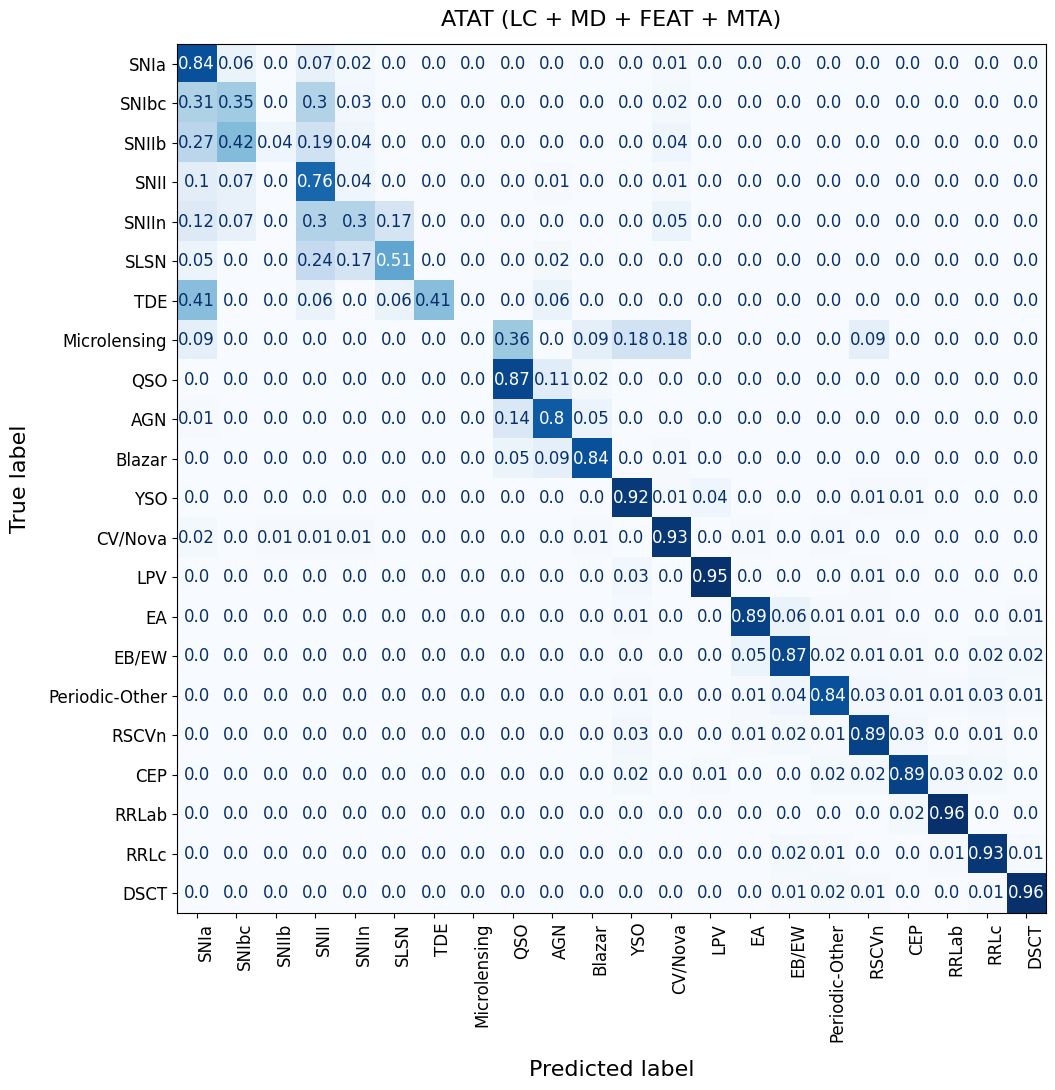

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT (LC + MD + FEAT + MTA)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.7235363028828607